# Lesson 3: Agentic Search

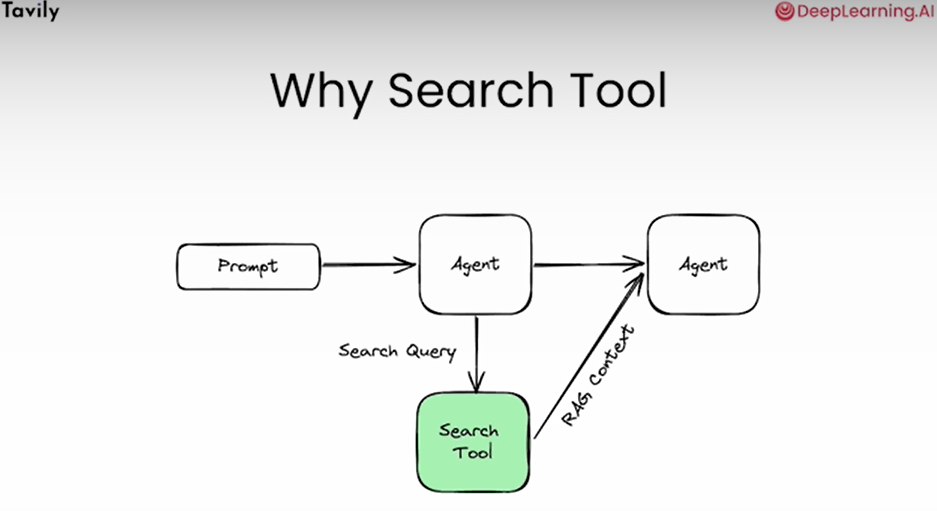

In zero shot learning an agent would receive a prompt and will produce an answer based on its static weights of the model.
As powerful as it's proven to be, there are many limitations to this process.

First, the data on this is dynamic. So we couldn't, for instance, ask about the scores from the game last night.

Secondly, in many use cases, we would want to know the sources of the information provided in the result. This can reduce hallucinations and smooth the friction of this human-computer interaction.

Looking at the slide, we can see the prompts received by the agent, which then decides to call the search tool.
Then the information found is returned to the agent.

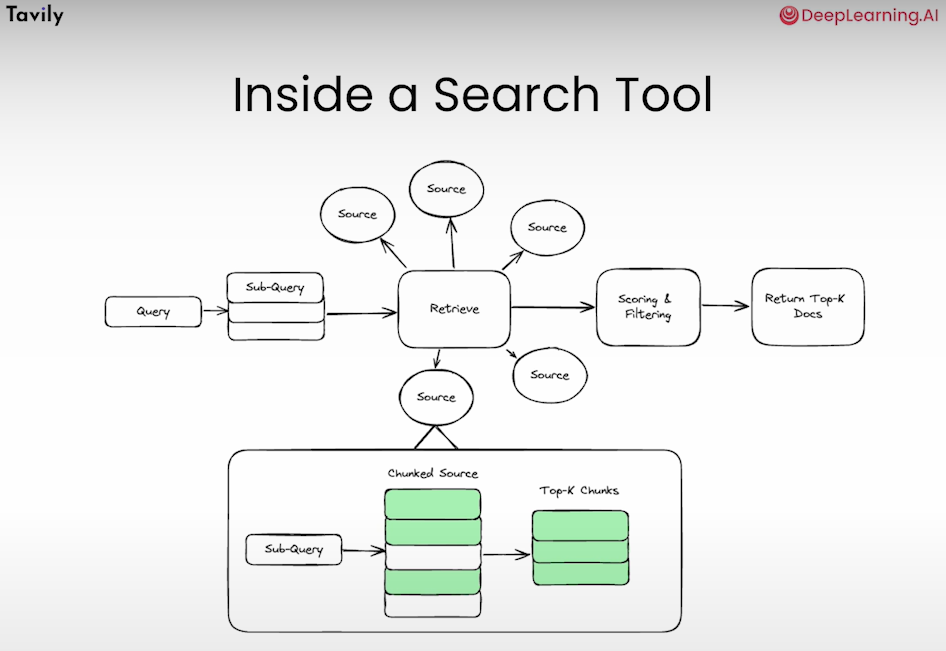

If the agent decides it will send the query to the search tool, 

the first step would work on understanding the question and divide it to sub-questions if needed. This is an important step because it can handle complex queries.
Then, for each subquery, the search tool will have to find the best source.
Choosing from multiple integrations.

For example, if an agent would ask "How is the weather in San Francisco?"
The search tool should use the weather API for best results.
the job doesn't end with finding the correct source.
The search tool would
then have to extract only the relevant information to the subquery.
A basic implementation of this can be achieved through a process
of chunking the source, and run a quick vector search to retrieve the top-K
chunks. 

After retrieving the data from its source,
the search tool would then score the results and filter
out the less relevant information.

In [1]:
# libraries
from dotenv import load_dotenv
import os
from tavily import TavilyClient

# load environment variables from .env file
_ = load_dotenv()

# connect
client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

In [2]:
# run search
result = client.search("What is in Nvidia's new Blackwell GPU?",
                       include_answer=True)

# print the answer
result["answer"]


'The Nvidia Blackwell GPU is a high-performance chip designed for AI training, boasting significant improvements over its predecessor, the H100 GPU. It promises a 7 to 30 times performance enhancement, with the Blackwell B200 tensor core chip featuring 208 billion transistors. This chip is claimed to reduce AI inference operating costs and energy consumption by up to 25 times compared to the H100. The Blackwell GPU architecture is intended to power real-time generative AI on trillion-parameter large language models, offering enhanced efficiency and performance for AI applications.'

## Regular search

In [3]:
# choose location (try to change to your own city!)

city = "San Francisco"

query = f"""
    what is the current weather in {city}?
    Should I travel there today?
    "weather.com"
"""

> Note: search was modified to return expected results in the event of an exception. High volumes of student traffic sometimes cause rate limit exceptions.

In [4]:
import requests
from bs4 import BeautifulSoup
from duckduckgo_search import DDGS
import re

ddg = DDGS()

def search(query, max_results=6):
    try:
        results = ddg.text(query, max_results=max_results)
        return [i["href"] for i in results]
    except Exception as e:
        print(f"returning previous results due to exception reaching ddg.")
        results = [ # cover case where DDG rate limits due to high deeplearning.ai volume
            "https://weather.com/weather/today/l/USCA0987:1:US",
            "https://weather.com/weather/hourbyhour/l/54f9d8baac32496f6b5497b4bf7a277c3e2e6cc5625de69680e6169e7e38e9a8",
        ]
        return results  


for i in search(query):
    print(i)

https://weather.com/weather/tenday/l/San Francisco CA USCA0987:1:US


In [5]:
def scrape_weather_info(url):
    """Scrape content from the given URL"""
    if not url:
        return "Weather information could not be found."
    
    # fetch data
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return "Failed to retrieve the webpage."

    # parse result
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup


> Note: This produces a long output, you may want to right click and clear the cell output after you look at it briefly to avoid scrolling past it.

In [6]:
# use DuckDuckGo to find websites and take the first result
url = search(query)[0]

# scrape first wesbsite
soup = scrape_weather_info(url)

print(f"Website: {url}\n\n")
print(str(soup.body)[:50000]) # limit long outputs

Website: https://weather.com/weather/tenday/l/San Francisco CA USCA0987:1:US


<body><div class="appWrapper DaybreakLargeScreen LargeScreen lightTheme twcTheme DaybreakLargeScreen--appWrapper--3kKUE gradients--cloudyFoggyNight--hTBfM gradients--cloudyFoggyNight-top--1Xd8n" id="appWrapper"><div class="region-meta"><div class="removeIfEmpty" id="WxuHtmlHead-meta-"></div></div><div class="region-topAds regionTopAds DaybreakLargeScreen--regionTopAds--2kcLJ"><div class="removeIfEmpty" id="WxuAd-topAds-53dce052-5465-4609-a555-c3a20ab64ab0"><div class="adWrapper BaseAd--adWrapper--1dWzA BaseAd--card--2G19u BaseAd--hide--3LkRr"><div class="adLabel BaseAd--adLabel--1LMu9">Advertisement</div><div class="ad_module BaseAd--ad_module--DeGCt subs-undefined BaseAd--placeholder--3IQan" id="WX_Hidden"></div></div></div><div class="removeIfEmpty" id="WxuAd-topAds-fe926b10-58bc-448a-ab09-47e692334250"><div class="adWrapper BaseAd--adWrapper--1dWzA BaseAd--card--2G19u BaseAd--hide--3LkRr"><div class="adLa

In [7]:
# extract text
weather_data = []
for tag in soup.find_all(['h1', 'h2', 'h3', 'p']):
    text = tag.get_text(" ", strip=True)
    weather_data.append(text)

# combine all elements into a single string
weather_data = "\n".join(weather_data)

# remove all spaces from the combined text
weather_data = re.sub(r'\s+', ' ', weather_data)
    
print(f"Website: {url}\n\n")
print(weather_data)

Website: https://weather.com/weather/tenday/l/San Francisco CA USCA0987:1:US


recents Weather Forecasts Radar & Maps News & Media Products Health & Wellness Account Lifestyle Privacy Specialty Forecasts 10 Day Weather - San Francisco, CA Today Fri 13 | Day Some clouds this morning will give way to generally sunny skies for the afternoon. High 71F. Winds WSW at 10 to 20 mph. Fri 13 | Night Partly to mostly cloudy. Low 54F. Winds WSW at 10 to 20 mph. Sat 14 Sat 14 | Day Partly cloudy. High 67F. Winds SW at 10 to 20 mph. Sat 14 | Night Partly cloudy skies. Areas of dense fog. Low near 55F. Winds W at 10 to 20 mph. Sun 15 Sun 15 | Day Mostly cloudy and becoming windy. Expect mist and reduced visibilities at times. High 66F. Winds W at 20 to 30 mph. Sun 15 | Night Partly cloudy. Low 54F. Winds WNW at 15 to 25 mph. Mon 16 Mon 16 | Day Sunshine along with some cloudy intervals. High 68F. Winds WNW at 10 to 20 mph. Mon 16 | Night Mostly clear skies. Low 53F. Winds W at 10 to 15 mph. Tue 17 Tu

## Agentic Search

In [8]:
# run search
result = client.search(query, max_results=1)

# print first result
data = result["results"][0]["content"]

print(data)

{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1726231551, 'localtime': '2024-09-13 05:45'}, 'current': {'last_updated_epoch': 1726231500, 'last_updated': '2024-09-13 05:45', 'temp_c': 15.2, 'temp_f': 59.4, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 2.7, 'wind_kph': 4.3, 'wind_degree': 188, 'wind_dir': 'S', 'pressure_mb': 1009.0, 'pressure_in': 29.79, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 90, 'cloud': 0, 'feelslike_c': 15.2, 'feelslike_f': 59.4, 'windchill_c': 13.7, 'windchill_f': 56.7, 'heatindex_c': 13.6, 'heatindex_f': 56.4, 'dewpoint_c': 11.3, 'dewpoint_f': 52.4, 'vis_km': 16.0, 'vis_miles': 9.0, 'uv': 1.0, 'gust_mph': 4.8, 'gust_kph': 7.7}}


In [9]:
import json
from pygments import highlight, lexers, formatters

# parse JSON
parsed_json = json.loads(data.replace("'", '"'))

# pretty print JSON with syntax highlighting
formatted_json = json.dumps(parsed_json, indent=4)
colorful_json = highlight(formatted_json,
                          lexers.JsonLexer(),
                          formatters.TerminalFormatter())

print(colorful_json)


{
    "location": {
        "name": "San Francisco",
        "region": "California",
        "country": "United States of America",
        "lat": 37.78,
        "lon": -122.42,
        "tz_id": "America/Los_Angeles",
        "localtime_epoch": 1726231551,
        "localtime": "2024-09-13 05:45"
    },
    "current": {
        "last_updated_epoch": 1726231500,
        "last_updated": "2024-09-13 05:45",
        "temp_c": 15.2,
        "temp_f": 59.4,
        "is_day": 0,
        "condition": {
            "text": "Clear",
            "icon": "//cdn.weatherapi.com/weather/64x64/night/113.png",
            "code": 1000
        },
        "wind_mph": 2.7,
        "wind_kph": 4.3,
        "wind_degree": 188,
        "wind_dir": "S",
        "pressure_mb": 1009.0,
        "pressure_in": 29.79,
        "precip_mm": 0.0,
        "precip_in": 0.0,
        "humidity": 90,
        "cloud": 0,
        "feelslike_c": 15.2,
        "feelslike_f": 59.4,
        "windchill_c": 13.7,
        "windchil

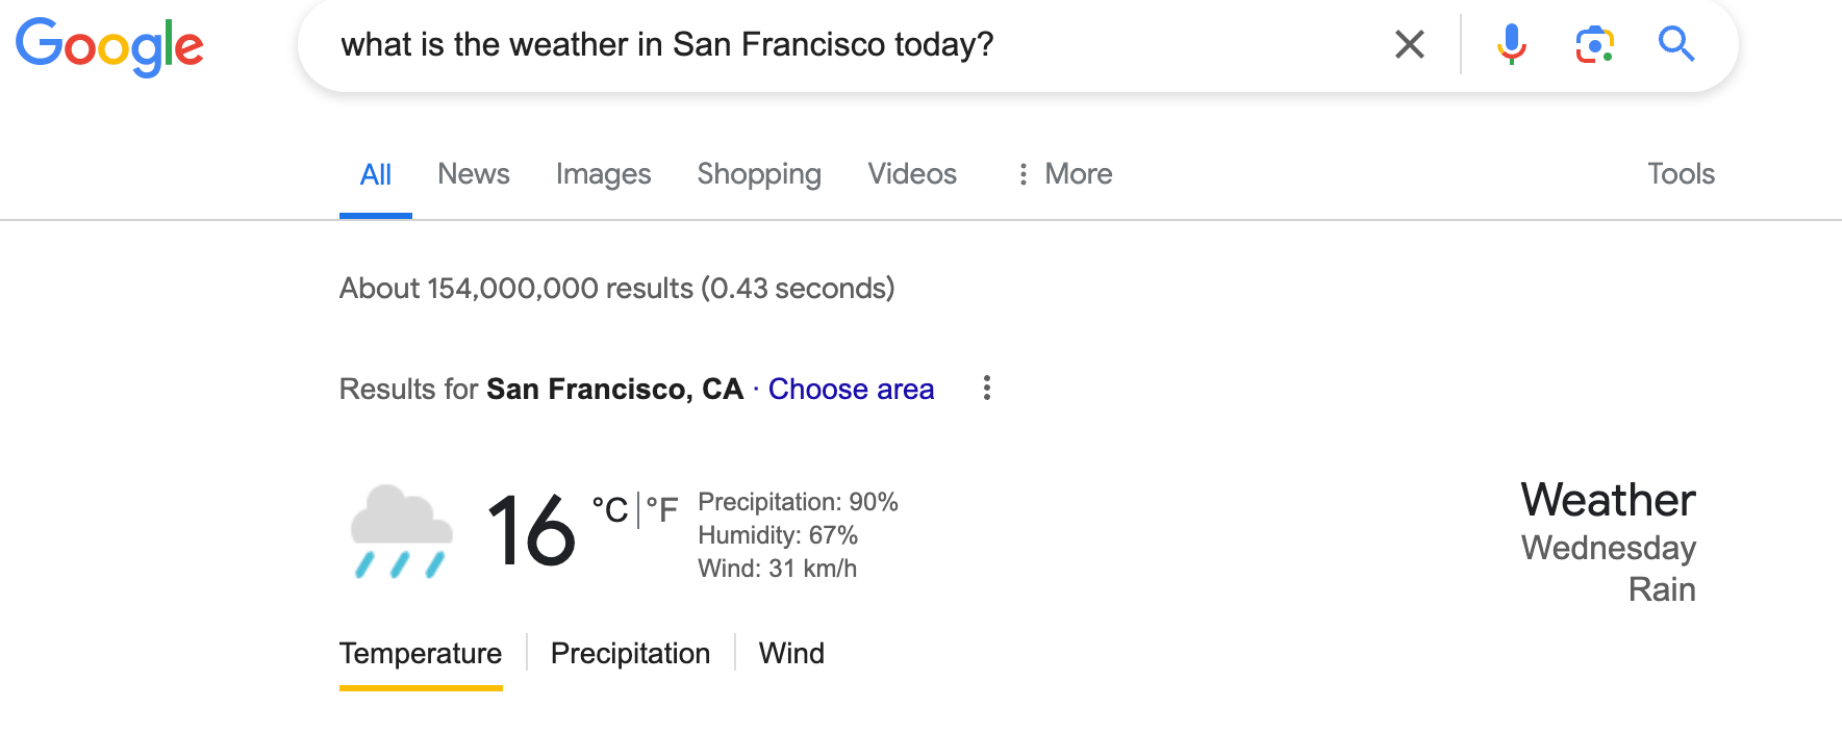